In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import spacy
import nltk
nlp = spacy.load("en_core_web_sm")
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.tokenize import word_tokenize

from collections import Counter
from PIL import Image
from io import BytesIO
from transformers import BertModel, BertTokenizer

from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation, PCA
from sklearn.preprocessing import StandardScaler

from keras.applications.vgg16 import VGG16

In [28]:
product_data = pd.read_excel("TaobaoProduct_En.xlsx")
product_data.head(2)

,Category,ID,Product Name,Price,Shipping Location,Product Description,Store Name,Store Link,Product Link,Product Image
0,Health protective gear,733229857662,Cotton knee warm old cold legs men and women j...,5.94,"Hangzhou, Zhejiang",Free shipping free factory shipping,Daily sale factory shop,'https://store.taobao.com/shop/view_shop.htm?a...,'https://item.taobao.com/item.htm?id=733229857662,'https://g-search2.alicdn.com/img/bao/uploaded...
1,fitness,742827915487,Healthy belly wheel automatic rebound abdomina...,20.72,"Hangzhou, Zhejiang",Free shipping from Amoy factory,Daily sale factory shop,'https://store.taobao.com/shop/view_shop.htm?a...,'https://item.taobao.com/item.htm?id=742827915487,'https://g-search2.alicdn.com/img/bao/uploaded...


# Data Cleaning + Tokenization + Remove Stop words + Stemming/Lemmatization

In [29]:
lemmatizer = WordNetLemmatizer() 
stop_words = set(stopwords.words('english'))

In [30]:
def preprocess_text(text):
    # Convert text to lowercase
    text = text.lower()
    # Remove punctuation and numbers
    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub(r'\d+', '', text)
    # Tokenize text
    tokens = nltk.word_tokenize(text)
    lemmatized = [lemmatizer.lemmatize(token) for token in tokens if token not in stop_words]
    return ' '.join(lemmatized)

# Apply the preprocessing to each description
product_data['processed_Name'] = product_data['Product Name'].apply(preprocess_text)
product_data['processed_Category'] = product_data['Category'].apply(preprocess_text)

# First approach - LDA (extract key words)

LDA Topic Modeling

- Create a document-term matrix

Matrix looks like:

Document / Term	Term1	Term2	Term3	...	TermN

DescriptionA	2	0	3	...	1

DescriptionB	0	1	1	...	0

DescriptionC	1	2	0	...	4

...	...	...	...	...	...

DescriptionM	3	0	1	...	2


Each 'DescriptionX' is a unique product description/name.

In [60]:
#1
# Set max_df to ignore terms that appear in more than 95% of the documents
# Set min_df to ignore terms that appear in less than 2 documents
vectorizer = CountVectorizer(max_df=0.95, min_df=2, stop_words='english')
dtm = vectorizer.fit_transform(product_data['processed_Name'])
dtmCat = vectorizer.fit_transform(product_data['processed_Category'])

#2
# vectorizer = CountVectorizer(max_df=0.85, min_df=2, stop_words='english')
# dtm = vectorizer.fit_transform(product_data['processed_descriptions'])

#3
#bigram / trigram
# vectorizer = CountVectorizer(ngram_range=(1, 3), stop_words='english')
# dtm = vectorizer.fit_transform(df['processed_description'])

#4
# vectorizer = TfidfVectorizer()
# tfidf_matrix = vectorizer.fit_transform(product_data['processed_descriptions'])
# tfidf_matrix


In [61]:
# Perform LDA
lda = LatentDirichletAllocation(n_components=25, random_state=0)  # 25 topics for now
lda.fit(dtm)
#lda.fit(dtmCat)

LatentDirichletAllocation(n_components=25, random_state=0)

In [62]:
# Function to display topics
def display_topics(model, feature_names, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("Topic %d:" % (topic_idx))
        print(" ".join([feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]]))

# Display top words in topics
display_topics(lda, vectorizer.get_feature_names(), 10)


Topic 0:
appliance main kitchen accessory tool stitch cross food small baby
Topic 1:
clock article sitting alarm home food small appliance baby yoga
Topic 2:
health household care equipment power tool type bed display decorative
Topic 3:
outdoor furniture carpet leisure storage jewelry patio lighting health decoration
Topic 4:
night outdoor vision telescope glass lamp dust finished fan fabric
Topic 5:
furniture cover dust protection display childrens yoga equipment fan fabric
Topic 6:
crib baby frame product bath picture photo cot yoga fabric
Topic 7:
baby stroller walker decoration cutlery food small appliance yoga equipment
Topic 8:
class clothing outdoor cabinet shelf yoga fan fabric extreme equipment
Topic 9:
pillow automotive interior supply tea set new throw fishing decoration
Topic 10:
equipment fishing motorcycle rider massage dust finished fan fabric extreme
Topic 11:
wine set glass pot cutlery decoration decorative display disposable diy
Topic 12:
military simulation fan flow

/Users/wtyjoycee/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


Ensure that the text preprocessing includes lowercase conversion, removal of punctuation, numbers, and stop words, along with stemming or lemmatization.

In [ ]:
# Create a document-term matrix




lda_model = LatentDirichletAllocation(n_components=10, max_iter=10, learning_method='online', random_state=0)
lda_model.fit(dtm)


In [ ]:
# Function to display topics
def display_topics(model, feature_names, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("Topic %d:" % (topic_idx))
        print(" ".join([feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]]))

# Display top words in topics
display_topics(lda, vectorizer.get_feature_names(), 10)

In [ ]:
product_data['processed_Name']

# Last approach tfidf_vectorizer + kmeans

In [48]:
tfidf_vectorizer = TfidfVectorizer()
tfidf_matrix = tfidf_vectorizer.fit_transform(product_data['processed_Name'].astype(str).tolist())

In [49]:
tfidf_matrix

<89374x15473 sparse matrix of type '<class 'numpy.float64'>'
	with 1259030 stored elements in Compressed Sparse Row format>

In [ ]:
# distortions = []
# K = range(5, 500)  
# for k in K:
#     kmeanModel = KMeans(n_clusters=k)
#     kmeanModel.fit(tfidf_matrix)
#     distortions.append(kmeanModel.inertia_)

# # Plotting
# plt.figure(figsize=(16,8))
# plt.plot(K, distortions, 'bx-')
# plt.xlabel('Number of clusters')
# plt.ylabel('Distortion')
# plt.title('The Elbow Method showing the optimal number of clusters')
# plt.show()


In [ ]:
num_clusters = 150  
km = KMeans(n_clusters=num_clusters)
km.fit(tfidf_matrix)
clusters = km.labels_.tolist()

product_data['Cluster'] = clusters

In [ ]:
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

# Assume tfidf_matrix is your TF-IDF matrix and num_clusters is a list of different cluster sizes you want to test
num_clusters = sorted(product_data_cluster['Cluster'].unique())  # Example cluster numbers
silhouette_scores = []

for k in range(0,150):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(tfidf_matrix)
    labels = kmeans.labels_
    score = silhouette_score(tfidf_matrix, labels)
    silhouette_scores.append(score)

# Plotting
plt.plot(num_clusters, silhouette_scores, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score for Different Number of Clusters')
plt.show()


In [ ]:
def get_top_terms_per_cluster(tfidf_vectorizer, km_model, n_terms = 2):
    # Get the feature names (words)
    order_centroids = km_model.cluster_centers_.argsort()[:, ::-1]
    try:
        # Try the newer method first
        terms = tfidf_vectorizer.get_feature_names_out()
    except AttributeError:
        # Fallback for older versions of scikit-learn
        terms = tfidf_vectorizer.get_feature_names()
    
    # Get top terms for each cluster
    top_terms = {}
    for i in range(num_clusters):
        top_terms[i] = ', '.join([terms[ind] for ind in order_centroids[i, :n_terms]])
    return top_terms

# Get top terms for each cluster
top_terms_per_cluster = get_top_terms_per_cluster(tfidf_vectorizer, km)

# ... rest of your code
product_data['Cluster_Name'] = product_data['Cluster'].map(top_terms_per_cluster)

In [ ]:
product_data_cluster.to_csv('product_data_cluster.csv')

In [53]:
def download_image(url):
    try:
        headers = {'User-Agent': 'Mozilla/5.0'}
        response = requests.get(url, headers=headers)
        response.raise_for_status()
        return Image.open(BytesIO(response.content))
    except requests.RequestException as e:
        print(f"Error downloading {url}: {e}")
        return None

def preprocess_image(image, target_size=(224, 224)):
    if image is not None:
        # Resize and convert to RGB
        image = image.resize(target_size).convert('RGB')
        # Convert to array
        image_array = np.array(image)
        # Normalize the image array
        image_array = image_array.astype('float32') / 255.0
        return image_array
    else:
        return None


In [ ]:
# Create a dictionary to store images by cluster (150)
clustered_images = {i: [] for i in range(num_clusters)} 

# assign product images into clusters
for index, row in product_data.iterrows():
    cluster = row['Cluster']
    image_url = row['Product Image'].strip("'")
    image = download_image(image_url)
    processed_image = preprocess_image(image)
    if processed_image is not None:
        clustered_images[cluster].append(processed_image)


Error downloading https://g-search3.alicdn.com/img/bao/uploaded/i4/i1/2214969314857/O1CN01hFZbKK1lkYa8LNyTN_!!2214969314857.jpg_0x0.jpg?O1CN01JSqc1R1JB0Iq5hr.jpg: 404 Client Error: Not Found for url: https://g-search3.alicdn.com/img/bao/uploaded/i4/i1/2214969314857/O1CN01hFZbKK1lkYa8LNyTN_!!2214969314857.jpg_0x0.jpg?O1CN01JSqc1R1JB0Iq5hr.jpg
Error downloading https://g-search3.alicdn.com/img/bao/uploaded/i4/i2/2210951114577/O1CN01lBTXsO1jgJfM4Ekq9_!!2210951114577.jpg: 404 Client Error: Not Found for url: https://g-search3.alicdn.com/img/bao/uploaded/i4/i2/2210951114577/O1CN01lBTXsO1jgJfM4Ekq9_!!2210951114577.jpg
Error downloading https://g-search2.alicdn.com/img/bao/uploaded/i4/i1/1865200230/O1CN01cg7GGD1DZNsW3sagP_!!1865200230.jpg: 404 Client Error: Not Found for url: https://g-search2.alicdn.com/img/bao/uploaded/i4/i1/1865200230/O1CN01cg7GGD1DZNsW3sagP_!!1865200230.jpg
Error downloading https://g-search3.alicdn.com/img/bao/uploaded/i4/i1/1865200230/O1CN01cg7GGD1DZNsW3sagP_!!186520023

In [ ]:
model = VGG16(weights='imagenet', include_top=False)

def extract_features(image, model):
    features = model.predict(image.reshape((1, image.shape[0], image.shape[1], image.shape[2])))
    return features.flatten()

cluster_features = {cluster: [extract_features(image, model) for image in images] for cluster, images in clustered_images.items()}


# Second approach (assign lables to each product)

Step 1: Extract Common Nouns/Labels from Product Names + Identify Common Labels

In [63]:
# Function to extract nouns from a sentence
def extract_nouns(product_name):
    nouns = [word for word, pos in nltk.pos_tag(nltk.word_tokenize(product_name)) if pos.startswith('NN')]
    return nouns

# Apply the function to the processed product names column
product_data['Nouns'] = product_data['processed_Name'].apply(extract_nouns)
product_data['categoryNouns'] = product_data['processed_Category'].apply(extract_nouns)


In [8]:
# Aggregate all nouns and find the most common ones
all_nouns = sum(product_data['Nouns'].tolist(), [])
common_labels = Counter(all_nouns).most_common()

print(common_labels)

[('baby', 19887), ('room', 16697), ('home', 12699), ('decoration', 11182), ('bedroom', 11067), ('lamp', 10871), ('living', 10870), ('light', 10715), ('cushion', 10678), ('wall', 10336), ('chair', 9728), ('car', 7859), ('mat', 7324), ('household', 7093), ('bed', 6858), ('childrens', 6845), ('cup', 6413), ('cover', 6383), ('desk', 6261), ('storage', 6249), ('winter', 6068), ('wood', 6062), ('protection', 5928), ('box', 5801), ('student', 5635), ('flower', 5510), ('sofa', 5450), ('child', 5388), ('table', 5365), ('men', 5327), ('bowl', 5156), ('tea', 5143), ('cotton', 5094), ('pot', 4916), ('hand', 4903), ('bag', 4883), ('cabinet', 4850), ('cloth', 4797), ('door', 4796), ('glass', 4513), ('frame', 4457), ('woman', 4245), ('ceiling', 4217), ('floor', 4158), ('coffee', 4127), ('night', 4013), ('pad', 4004), ('luxury', 3799), ('waterproof', 3757), ('outdoor', 3745), ('equipment', 3684), ('curtain', 3671), ('garden', 3439), ('seat', 3411), ('office', 3395), ('girl', 3313), ('autumn', 3254), (

In [64]:
# Aggregate all nouns and find the most common ones
all_nouns_cat = sum(product_data['categoryNouns'].tolist(), [])
common_labels_cat = Counter(all_nouns_cat).most_common()

print(common_labels_cat)

[('_', 27360), ('baby', 8969), ('lamp', 7425), ('supply', 4911), ('equipment', 4816), ('furniture', 4492), ('accessory', 4475), ('table', 3743), ('outdoor', 3676), ('product', 3662), ('cushion', 3627), ('wine', 3624), ('ware', 3533), ('fabric', 3489), ('tool', 3329), ('crib', 3315), ('cup', 2476), ('health', 2447), ('curtain', 2442), ('glass', 2436), ('fan', 2428), ('flower', 2428), ('simulation', 2428), ('night', 2424), ('floor', 2422), ('appliance', 2418), ('set', 2405), ('patio', 2401), ('clock', 2398), ('jewelry', 2368), ('pad', 2358), ('frame', 2316), ('tent', 2278), ('sofa', 2088), ('class', 2044), ('care', 1783), ('fitness', 1271), ('stroller', 1258), ('walker', 1258), ('bag', 1258), ('spotlight', 1256), ('car', 1248), ('cleaning', 1248), ('article', 1246), ('water', 1238), ('kettle', 1238), ('gear', 1236), ('interior', 1236), ('roller', 1234), ('sport', 1234), ('dust', 1231), ('protection', 1231), ('cover', 1231), ('telescope', 1228), ('vision', 1228), ('yoga', 1228), ('bath', 

Alternative: Extract Common Nouns/Labels but only functional from Product Names

In [15]:
# Define a function to extract functional nouns
def extract_functional_nouns(text):
    # Process the text
    doc = nlp(text)
    # Extract functional nouns by filtering on POS tags
    functional_nouns = [token.text for token in doc if token.pos_ in ['NOUN', 'PROPN']]
    return functional_nouns

# Apply the function to each row in the DataFrame
product_data['functional_nouns'] = product_data['processed_Name'].apply(extract_functional_nouns)


In [16]:
# Aggregate all nouns and find the most common ones
all_nouns = sum(product_data['functional_nouns'].tolist(), [])
common_labels = Counter(all_nouns).most_common()

print(common_labels)

[('baby', 20996), ('bed', 17186), ('room', 16686), ('light', 15572), ('lamp', 14994), ('table', 14273), ('home', 12349), ('living', 11894), ('wall', 11470), ('decoration', 11187), ('bedroom', 11066), ('cushion', 10623), ('chair', 10620), ('mat', 8632), ('car', 7859), ('household', 7583), ('cloth', 7299), ('flower', 7210), ('cup', 7201), ('desk', 6672), ('sofa', 6580), ('winter', 6543), ('storage', 6271), ('child', 6247), ('wood', 6106), ('box', 6032), ('protection', 5926), ('tea', 5697), ('student', 5687), ('bowl', 5401), ('bag', 5326), ('men', 5317), ('cotton', 5099), ('pot', 5077), ('door', 5049), ('hand', 4878), ('cabinet', 4824), ('frame', 4794), ('cover', 4788), ('accessory', 4737), ('pillow', 4666), ('glass', 4547), ('girl', 4451), ('pad', 4446), ('wine', 4354), ('waterproof', 4348), ('woman', 4238), ('curtain', 4226), ('ceiling', 4217), ('floor', 4158), ('coffee', 4158), ('bedside', 4103), ('childrens', 4079), ('night', 4013), ('fishing', 3927), ('outdoor', 3878), ('autumn', 380

Another way to identify common labels

In [ ]:
def tokenize_and_tag(product_name):
    tokens = word_tokenize(product_name.lower())
    stop_words = set(stopwords.words('english'))
    tokens = [token for token in tokens if token.isalpha() and token not in stop_words]
    return nltk.pos_tag(tokens)

# Apply the function to the product names
product_data['POS_Tags'] = product_data['processed_Name'].apply(tokenize_and_tag)

# Flatten the list of POS tag lists and keep only nouns
all_nouns = [word for sublist in product_data['POS_Tags'] for word, pos in sublist if pos.startswith('NN')]

# Get the most common nouns
noun_freq = Counter(all_nouns)
common_nouns = noun_freq.most_common()

In [11]:
# Print out the most common nouns for manual review
for noun, freq in common_nouns:
    print(f"{noun}: {freq}")

babi: 18439
room: 16697
children: 13699
light: 13330
decor: 13156
home: 12513
lamp: 11228
tabl: 11182
bedroom: 11085
cushion: 10749
wall: 10518
chair: 10011
car: 7859
simpl: 7793
mat: 7618
household: 7081
cup: 6779
cover: 6439
cloth: 6370
desk: 6357
wood: 6025
winter: 5996
box: 5878
flower: 5857
student: 5645
bed: 5604
sofa: 5499
men: 5327
bowl: 5206
bag: 5174
tea: 5154
cotton: 5075
pot: 5035
hand: 4904
door: 4903
cabinet: 4892
storag: 4647
frame: 4628
glass: 4518
larg: 4399
creativ: 4235
women: 4179
floor: 4165
pad: 4126
hang: 4120
wash: 4114
bedsid: 4055
night: 4013
paint: 3961
waterproof: 3877
coffe: 3824
electr: 3732
curtain: 3668
portabl: 3600
outdoor: 3577
camp: 3572
seat: 3473
girl: 3438
garden: 3428
ceil: 3410
tool: 3298
wine: 3216
autumn: 3169
cat: 3160
water: 3034
protect: 2963
clock: 2955
sticker: 2951
custom: 2871
eye: 2867
equip: 2773
leg: 2721
crib: 2662
suppli: 2589
steel: 2555
set: 2553
massag: 2532
sport: 2471
round: 2460
rod: 2457
jewelri: 2397
balconi: 2392
pillow: 2

Step 3: Assign Labels to Products

In [17]:
def assign_labels(nouns, common_labels):
    common_nouns = [noun for noun, _ in common_labels]
    # Find the first noun in the common list that appears in the product's nouns
    labels = [noun for noun in nouns if noun in common_nouns]
    return labels[0] if labels else 'Other'

# Apply the function to your nouns column, and make sure to pass the list of common nouns
product_data['Labels'] = product_data['Nouns'].apply(lambda x: assign_labels(x, common_labels))
product_data['Labels_functional'] = product_data['functional_nouns'].apply(lambda x: assign_labels(x, common_labels))
product_data['Labels_Categories'] = product_data['functional_nouns'].apply(lambda x: assign_labels(x, common_labels))

In [57]:
product_data[product_data['Labels'] == 'baby']

,Category,ID,Product Name,Price,Shipping Location,Product Description,Store Name,Store Link,Product Link,Product Image,processed_Name,Nouns,Labels,functional_nouns,Labels_functional,Cluster
25,Crib product,554544762166,Baby bedding for children crib girth for baby ...,50.00,"Guangzhou, Guangdong",Exempt from postage,Angel Garden baby,'https://store.taobao.com/shop/view_shop.htm?a...,'https://item.taobao.com/item.htm?id=554544762166,'https://g-search2.alicdn.com/img/bao/uploaded...,baby bedding child crib girth baby crib antico...,"[baby, crib, baby, crib, anticollision, patchw...",baby,"[baby, child, crib, girth, baby, crib, anticol...",baby,2
26,Baby stroller _ Baby Walker,693548158741,Baby walker anti-O-legs baby multi-functional ...,79.80,"Nanjing, Jiangsu",Old for new free shipping,Suning shopping official flagship store,'https://store.taobao.com/shop/view_shop.htm?a...,'https://item.taobao.com/item.htm?id=693548158741,'https://g-search1.alicdn.com/img/bao/uploaded...,baby walker antiolegs baby multifunctional ant...,"[baby, walker, antirollover, trolley, baby, pu...",baby,"[baby, walker, antiolegs, baby, antirollover, ...",baby,2
31,Baby cutlery,621393599603,Nikkang baby food bowl Children's stainless st...,29.90,"Changzhou, Jiangsu",Exempt from postage,Rikang flagship store,'https://store.taobao.com/shop/view_shop.htm?a...,'https://item.taobao.com/item.htm?id=621393599603,'https://g-search3.alicdn.com/img/bao/uploaded...,nikkang baby food bowl childrens stainless ste...,"[baby, food, bowl, steel, bowl, baby, dinner, ...",baby,"[baby, food, bowl, steel, bowl, baby, dinner, ...",baby,2
39,Night lamp,699116095835,Bedside nightlight plugged into baby eye prote...,2.45,"Shantou, Guangdong",Exempt from postage,Linlang home lighting shop,'https://store.taobao.com/shop/view_shop.htm?a...,'https://item.taobao.com/item.htm?id=699116095835,'https://g-search2.alicdn.com/img/bao/uploaded...,bedside nightlight plugged baby eye protection...,"[baby, eye, protection, control, bedroom, slee...",baby,"[bedside, baby, eye, protection, control, bedr...",bedside,2
72,Sleeping bag,41396072607,Baby sleeping bag Spring and autumn thin anti-...,49.50,"Nantong, Jiangsu",Free shipping insurance free shipping baby,Xiao Erlang flagship store,'https://store.taobao.com/shop/view_shop.htm?a...,'https://item.taobao.com/item.htm?id=41396072607,'https://g-search3.alicdn.com/img/bao/uploaded...,baby sleeping bag spring autumn thin antikick ...,"[baby, bag, spring, autumn, antikick, autumn, ...",baby,"[baby, bag, spring, autumn, thin, antikick, au...",baby,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
89232,Baby collision avoidance,683790441940,Baby anti-fall device Baby protective cap pill...,19.90,Shanghai,Exempt from postage,Orange Sea mother and baby store,'https://store.taobao.com/shop/view_shop.htm?a...,'https://item.taobao.com/item.htm?id=683790441940,'https://g-search3.alicdn.com/img/bao/uploaded...,baby antifall device baby protective cap pillo...,"[baby, device, baby, cap, pillow, learn, child...",baby,"[baby, antifall, device, baby, cap, pillow, wa...",baby,2
89234,Baby bath,722414104595,Red baby Elephant parent-child shower gel for ...,46.00,"Hangzhou, Zhejiang",Free shipping covered,Red elephant genuine mother and baby shop,'https://store.taobao.com/shop/view_shop.htm?a...,'https://item.taobao.com/item.htm?id=722414104595,'https://g-search1.alicdn.com/img/bao/uploaded...,red baby elephant parentchild shower gel infan...,"[baby, parentchild, shower, gel, infant, child...",baby,"[red, baby, elephant, parentchild, shower, gel...",red,2
89312,Baby Carrier _ Toddler Belt,746832994551,Baby walking belt anti-fall lifting belt anti-...,29.50,"Taizhou, Zhejiang",Free shipping for new products,Shakha's flagship store,'https://store.taobao.com/shop/view_shop.htm?a...,'https://item.taobao.com/item.htm?id=746832994551,'https://g-search3.alicdn.com/img/bao/uploaded...,baby walking belt antifall lifting belt antist...,"[baby, lifting, 

Step 4: Cluster Products Based on Labels

In [18]:
# Group products by labels (simple approach)
grouped_products = product_data.groupby('Labels')
grouped_products_functional = product_data.groupby('Labels_functional')

In [11]:
product_data['Labels'].unique()

array(['cotton', 'rebound', 'mat', ..., 'milledream', 'baoli', 'bonn'],
      dtype=object)

In [19]:
print(len(product_data))
print(len(product_data['Labels'].unique()))
print(len(product_data['Labels_functional'].unique()))

89374
4903
5482


Step 5: Analyze Relationships Within Each Category/Label

In [23]:
# Example analysis of price within each label
for label, group in grouped_products:
    print(f"{label}: Average price = {group['Price'].mean()}")

%: Average price = 52.99
*: Average price = 5.642499999999999
/: Average price = 189.42624999999998
//: Average price = 51.525
3-in-1: Average price = 59.9
A: Average price = 498.1166666666666
A+: Average price = 128.0
A+B: Average price = 102.66666666666667
A-level: Average price = 72.66666666666667
A3: Average price = 43.333333333333336
A3D: Average price = 2182.3333333333335
A3a4: Average price = 3.9
A4: Average price = 52.91428571428571
A5: Average price = 1.895
A5A4: Average price = 8.8
A60: Average price = 0.2
AA: Average price = 22.35
AAA: Average price = 23.324615384615388
AAN: Average price = 9.8
AB: Average price = 49.0
ABCD: Average price = 9.9
ABCmokoo: Average price = 58.0
ABF: Average price = 17.8
ABS: Average price = 5.9075
ACETEC: Average price = 66.0
AD: Average price = 76.5
AGV: Average price = 58.0
AI: Average price = 0.8
AIDS: Average price = 60.640270270270285
AK: Average price = 28.9
AKAKA: Average price = 9.8
ALEDIS: Average price = 1094.8
ALF: Average price = 18

H2S: Average price = 779.0
HAGLOFS: Average price = 108.0
HARIO: Average price = 80.0
HARSIDE: Average price = 1441.7857142857142
HB: Average price = 676.0
HD: Average price = 839.3849999999999
HEAD: Average price = 232.15636363636366
HEAR: Average price = 106.0
HEISOU: Average price = 25.0
HETAI: Average price = 19.225
HIJACK: Average price = 18.8
HIKEMAN: Average price = 9.14
HJJJ: Average price = 6.900000000000001
HK: Average price = 164.1
HLA/: Average price = 275.0
HM: Average price = 199.0
HOMEFAITH: Average price = 569.0
HOTO: Average price = 269.0
HOTSSS: Average price = 106.0
HP: Average price = 77.90909090909089
HUAWEI: Average price = 1309.35
HUGZ: Average price = 49.0
Haier: Average price = 1935.34
Haier/: Average price = 1502.2857142857142
Haima: Average price = 2.0
Hainuo: Average price = 61.0
Hair: Average price = 17.35578947368421
Hairpin: Average price = 8.766666666666666
Hairroot: Average price = 4.35
Hairy: Average price = 19.0
Hakada: Average price = 656.2
Hakata: A

Ming: Average price = 9.7
Mingjia: Average price = 28.8
Mingsheng: Average price = 19.9
Mini: Average price = 50.77548148148147
Miniature: Average price = 35.7875
Minibay: Average price = 119.0
Minibox: Average price = 228.6
Minimalist: Average price = 134.15093457943922
Minivan: Average price = 6.16
Minor: Average price = 8.4
Minoyaki: Average price = 368.86
Mirror: Average price = 17.343636363636364
Mirsila: Average price = 5.9
Miss: Average price = 1162.2666666666667
Mist: Average price = 8.9
Mistreasurer: Average price = 153.0
Misty: Average price = 1.8
Mite: Average price = 3484.0
Mitsuo: Average price = 82.5
Mixer: Average price = 125.0
Miyazaki: Average price = 27.9
Miyou: Average price = 131.92
Mizuno: Average price = 115.08000000000001
Mlinsen: Average price = 132.075
Mmoptop: Average price = 199.0
Mo: Average price = 1601.3596874999998
Mobile: Average price = 51.74155555555557
Mocha: Average price = 31.324999999999992
Modal: Average price = 26.700000000000003
Model: Average p

Vtech: Average price = 174.45
W: Average price = 7.2
W5482: Average price = 74.16
WASSUP: Average price = 98.32222222222222
WELLHIKE: Average price = 45.666666666666664
WLB: Average price = 108.0
WLEN: Average price = 418.0
WOODSOON: Average price = 133.0
WORX: Average price = 119.0
WOSAWE: Average price = 53.5
WSK: Average price = 20.0
WU129: Average price = 249.0
WU130X: Average price = 186.0
WU131X: Average price = 219.0
WUXIN: Average price = 32.23333333333333
Wabi: Average price = 1580.0
Wabi-sabi: Average price = 113.37142857142855
Wabi-sabins: Average price = 80.0
Wadi: Average price = 64.9
Waffle: Average price = 15.9
Waist: Average price = 175.1277777777778
Waistband: Average price = 7.236
Walker: Average price = 168.0
Walkers: Average price = 39.0
Wall: Average price = 42.17561797752802
Wallet: Average price = 6.99
Walnut: Average price = 511.9961538461539
Walson: Average price = 45.44000000000001
Wan: Average price = 15.8
Wanchang: Average price = 1031.0
Wang: Average price 

pull-out: Average price = 6.9
pull-up: Average price = 49.0
puller: Average price = 11.860000000000003
pulley: Average price = 8.166666666666666
pulse: Average price = 159.0
pumpkin: Average price = 92.96
punch: Average price = 7.755
puppet: Average price = 18.8
pure: Average price = 152.9232
purminerals: Average price = 2376.0
puroo: Average price = 79.0
puroo10X25: Average price = 138.0
purple: Average price = 238.2459090909091
purpose: Average price = 33.0675
push: Average price = 2.8
push-up: Average price = 68.0
pvc: Average price = 10.834999999999999
python: Average price = 109.0
qin: Average price = 12.9
quail: Average price = 1.98
quality: Average price = 34.808510638297875
quantity: Average price = 14.126666666666665
quick-drying: Average price = 48.96
quicksand: Average price = 22.0
quilt: Average price = 81.775
quotes: Average price = 6.0
rabbit: Average price = 27.471000000000004
rack: Average price = 51.51
radar: Average price = 2.905
rafting: Average price = 49.0
rail: Av

In [20]:
product_data.to_csv('product_data_labels.csv', index=False)

In [21]:
product_data.columns

Index(['Category', 'ID', 'Product Name', 'Price', 'Shipping Location',
       'Product Description', 'Store Name', 'Store Link', 'Product Link',
       'Product Image'],
      dtype='object')

# Third approach 

In [5]:
product_data_labels = pd.read_csv("product_data_labels.csv")

In [26]:
product_data_labels['processed_Name'][0]

'cotton knee warm old cold leg men woman joint thin summer old air conditioning room four cold sheath'

# kmeans for clustering

In [67]:
labels_str = [''.join(labels) if labels else '' for labels in product_data['Labels']]

# Initialize the vectorizer
tfidf_vectorizer = TfidfVectorizer(max_df=0.85, min_df=2, max_features=500)

# Apply the vectorizer to the labels
tfidf_matrix = tfidf_vectorizer.fit_transform(product_data['Labels'])

In [73]:
vectorizer = CountVectorizer(max_df=0.85, min_df=2, stop_words='english')
dtm = vectorizer.fit_transform(product_data['Labels'])


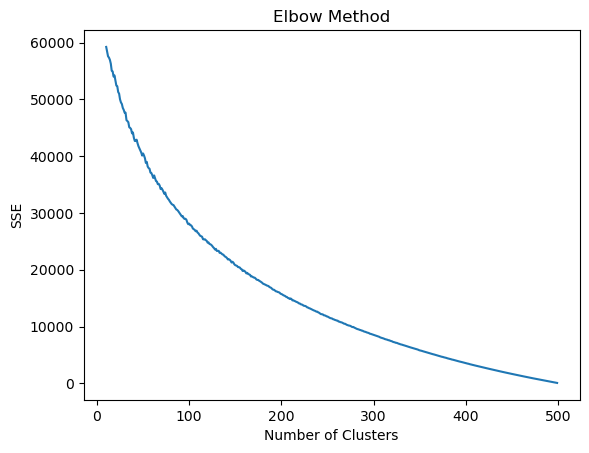

In [55]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

sse = {}
for k in range(10, 500):  
    kmeans = KMeans(n_clusters=k, max_iter=1000).fit(tfidf_matrix)
    sse[k] = kmeans.inertia_ 

plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of Clusters")
plt.ylabel("SSE")
plt.title("Elbow Method")
plt.show()


In [ ]:
silhouette_scores = []
K = range(10, 151, 10)
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(tfidf_matrix)
    score = silhouette_score(tfidf_matrix, kmeans.labels_)
    silhouette_scores.append(score)
    print(f"Number of clusters: {k}, Silhouette score: {score}")

In [ ]:
optimal_k = K[silhouette_scores.index(max(silhouette_scores))]


In [77]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=150, max_iter=1000, random_state=42)
kmeans.fit(tfidf_matrix)


KMeans(max_iter=1000, n_clusters=150, random_state=42)

In [78]:
product_data['Cluster'] = kmeans.labels_
order_centroids = kmeans.cluster_centers_.argsort()[:, ::-1]

# Get the terms from the TF-IDF Vectorizer
terms = tfidf_vectorizer.get_feature_names_out()

# Print the top terms for each cluster
for i in range(kmeans.n_clusters):
    print(f"Cluster {i}: ", end='')
    for ind in order_centroids[i, :10]: 
        print(f"{terms[ind]} ", end='')
    print()

Cluster 0: style yu film energy entrance entry europe explorer eye fabric 
Cluster 1: aluminum bala clearance wormwood monoculars downlight table ebony fan cliff 
Cluster 2: baby yu emergency entrance entry europe explorer eye fabric factory 
Cluster 3: ceiling yu finger entrance entry europe explorer eye fabric factory 
Cluster 4: floor yu film energy entrance entry europe explorer eye fabric 
Cluster 5: luxury embroidery energy entrance entry europe explorer eye fabric factory 
Cluster 6: chair yu finger entrance entry europe explorer eye fabric factory 
Cluster 7: living yu film energy entrance entry europe explorer eye fabric 
Cluster 8: round figure emergency energy entrance entry europe explorer eye fabric 
Cluster 9: garden yu finger entrance entry europe explorer eye fabric factory 
Cluster 10: crib yu finger entrance entry europe explorer eye fabric factory 
Cluster 11: car yu finger entrance entry europe explorer eye fabric factory 
Cluster 12: wall yu embroidery energy entra

In [50]:
# Print the top terms per cluster
order_centroids = kmeans.cluster_centers_.argsort()[:, ::-1]
terms = tfidf_vectorizer.get_feature_names_out()

for i in range(50):
    print(f"Cluster {i}: ", end='')
    for ind in order_centroids[i, :10]:  
        print(f"{terms[ind]} ", end='')
    print()


Cluster 0: barbecue yu emergency entrance entry europe explorer eye fabric factory 
Cluster 1: sofa cream yoga seat carpet sport cartoon wine cloth lamp 
Cluster 2: baby yu emergency entrance entry europe explorer eye fabric factory 
Cluster 3: car yu finger entrance entry europe explorer eye fabric factory 
Cluster 4: jewelry yu film energy entrance entry europe explorer eye fabric 
Cluster 5: simple yu figure energy entrance entry europe explorer eye fabric 
Cluster 6: bedroom yu finger entry europe explorer eye fabric factory family 
Cluster 7: wood yu film energy entrance entry europe explorer eye fabric 
Cluster 8: child yu film entrance entry europe explorer eye fabric factory 
Cluster 9: living yu film energy entrance entry europe explorer eye fabric 
Cluster 10: childrens yu film entrance entry europe explorer eye fabric factory 
Cluster 11: bed yu finger entry europe explorer eye fabric factory family 
Cluster 12: raishi yu figure energy entrance entry europe explorer eye fabr

In [1]:
# # Evaluate the clusters using silhouette score
# silhouette_avg = silhouette_score(tfidf_matrix, kmeans.labels_)
# print(f"Silhouette Score: {silhouette_avg}")

# # Visualize the clusters using PCA
# pca = PCA(n_components=2)
# reduced_features = pca.fit_transform(tfidf_matrix.toarray())

# # Plotting the reduced data
# plt.scatter(reduced_features[:,0], reduced_features[:,1], c=kmeans.labels_)
# plt.xlabel('PCA Feature 1')
# plt.ylabel('PCA Feature 2')
# plt.title('Cluster Visualization with PCA')
# plt.colorbar()
# plt.show()


In [54]:
silhouette_avg = silhouette_score(tfidf_matrix, kmeans.labels_)
print(f"Silhouette Score: {silhouette_avg}")

Silhouette Score: 0.45049688166275903
